# PART 5: Inductive Biases of Models: Locality Biases

### Imports

In [1]:
!pip install timm transformers
!pip install torchsummary

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader,Subset
import timm
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2


# import clip
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.4 MB/s eta 0:00:00


device(type='cuda')

In [11]:
# CIFAR-10 dataset loading and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for models like ViT and CLIP
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize CIFAR-10
])

train_dataset_CIFAR10 = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset_CIFAR10  = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader_CIFAR10 = DataLoader(dataset=train_dataset_CIFAR10, batch_size=128, shuffle=True, num_workers=4)
test_loader_CIFAR10  = DataLoader(dataset=test_dataset_CIFAR10, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


### Creating a Subset Dataset of CIFAR 10 test set
Total Images 1000 with
100 images of each class

In [12]:
class_counts = {i: 0 for i in range(10)}  # Dictionary to keep track of the count of images per class
selected_indices = []

# Iterate through the dataset to select 100 images per class
for idx, (image, label) in enumerate(test_dataset_CIFAR10):
    if class_counts[label] < 100:  # If we haven't selected 100 images for this class yet
        selected_indices.append(idx)
        class_counts[label] += 1

    if len(selected_indices) >= 1000:
        break

# Create a subset of the CIFAR-10 test set using the selected indices
subset_test_CIFAR10 = Subset(test_dataset_CIFAR10, selected_indices)

# Create a DataLoader for the subset
subset_test_loader_CIFAR10 = DataLoader(dataset=subset_test_CIFAR10, batch_size=128, shuffle=False, num_workers=4)

test_dataset_CIFAR10 = subset_test_CIFAR10
test_loader_CIFAR10  = subset_test_loader_CIFAR10

In [13]:
total_images = len(subset_test_loader_CIFAR10.dataset)

print(f"Total number of images in subset: {total_images}")

for batch_idx, (images, labels) in enumerate(subset_test_loader_CIFAR10):
    print(f"Batch {batch_idx + 1}:")
    print(f"  - Images size: {images.size()}")
    print(f"  - Labels size: {labels.size()}")
    if batch_idx == 0:
        break


Total number of images in subset: 1000
Batch 1:
  - Images size: torch.Size([128, 3, 224, 224])
  - Labels size: torch.Size([128])


In [14]:
# Load CIFAR-10
# transform = transforms.Compose([transforms.ToTensor()])
# cifar10_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# cifar10_loader = torch.utils.data.DataLoader(cifar10_data, batch_size=64, shuffle=True)

# Display function using matplotlib
def show_image(image, title=''):
    plt.figure(figsize=(3, 3))
    image = image.detach().permute(1, 2, 0).numpy()  # Detach and convert tensor to numpy format (H, W, C)
    image = np.clip(image, 0, 1)  # Ensure pixel values are in the range [0, 1]
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

### Training Loop And Testing Loop

In [15]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=3):
    model = model.to(device)
    model.train()

    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        accuracy = 100 * correct / total

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return train_losses, model

def evaluate_model(model, test_loader, criterion, device):

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    loss_total = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = loss_total / len(test_loader)

    print(f"\nModel Evaluation - Accuracy: {accuracy:.2f}% | Loss: {avg_loss:.4f}")

    return accuracy, avg_loss

### FineTuning the Models on Cifar 10

In [16]:
train_loader = train_loader_CIFAR10
test_loader = test_loader_CIFAR10

VIT

In [ ]:
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
# Freeze parameters of the backbone
for param in vit_model.parameters():
    param.requires_grad = False

# Replace the classifier head with a new head for CIFAR-10 (10 classes)
vit_model.head = nn.Linear(vit_model.head.in_features, 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.0001)

#training
train_losses, trained_model = train_model(vit_model , train_loader, criterion, optimizer, device, epochs=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

100%|██████████| 391/391 [09:28<00:00,  1.46s/it]


Epoch [1/3], Loss: 0.5314, Accuracy: 88.70%


100%|██████████| 391/391 [09:23<00:00,  1.44s/it]


Epoch [2/3], Loss: 0.1382, Accuracy: 96.71%


100%|██████████| 391/391 [09:23<00:00,  1.44s/it]

Epoch [3/3], Loss: 0.1020, Accuracy: 97.26%


VGG -16

In [ ]:
vgg_model = timm.create_model('vgg16', pretrained=True)

# Freeze the feature extractor backbone
for param in vgg_model.parameters():
    param.requires_grad = False

# Replace the classifier head with a new head for CIFAR-10 (10 classes)
vgg_model.head.fc = nn.Linear(vgg_model.head.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.0001)

#training
train_losses, trained_model = train_model(vgg_model , train_loader, criterion, optimizer, device, epochs=3)

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

100%|██████████| 391/391 [05:27<00:00,  1.20it/s]


Epoch [1/3], Loss: 1.0912, Accuracy: 69.30%


100%|██████████| 391/391 [05:27<00:00,  1.20it/s]


Epoch [2/3], Loss: 0.7064, Accuracy: 76.90%


100%|██████████| 391/391 [05:27<00:00,  1.19it/s]

Epoch [3/3], Loss: 0.6334, Accuracy: 78.58%


ResNet

In [ ]:
resnet_model = timm.create_model('resnet101', pretrained=True)

# Freeze the feature extractor backbone
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the classifier head with a new head for CIFAR-10 (10 classes)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

#training
train_losses, trained_model = train_model(resnet_model , train_loader, criterion, optimizer, device, epochs=3)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

100%|██████████| 391/391 [04:38<00:00,  1.40it/s]


Epoch [1/3], Loss: 1.3456, Accuracy: 68.80%


100%|██████████| 391/391 [04:39<00:00,  1.40it/s]


Epoch [2/3], Loss: 0.8481, Accuracy: 74.62%


100%|██████████| 391/391 [04:38<00:00,  1.40it/s]

Epoch [3/3], Loss: 0.7428, Accuracy: 76.59%


CLIP

In [17]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
cifar_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

clip_model.eval()

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = [f"a photo of a {class_name}" for class_name in class_names]

# Zero-shot evaluation on the test dataset with accuracy computation
correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating", leave=True):
        images = [img.to(device) for img in images]
        targets = targets.to(device)

        # Process inputs for the CLIP model
        inputs = cifar_processor(text=labels, images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)

        # Forward pass
        outputs = clip_model(**inputs)

        # Get image-text similarity scores
        logits_per_image = outputs.logits_per_image

        # Compute probabilities using softmax
        probs = logits_per_image.softmax(dim=1)

        # Get predicted labels (as indices)
        preds = torch.argmax(probs, dim=1)

        # Calculate accuracy
        correct += (preds == targets).sum().item()
        total += targets.size(0)

accuracy = correct / total * 100
print(f"\nAccuracy: {accuracy:.2f}%")


Evaluating: 100%|██████████| 8/8 [00:49<00:00,  6.20s/it]


Accuracy: 95.30%


In [18]:
CLIP_Accuracy = accuracy

# 1 - Localized Noise Injection In Dataset

In [19]:
def add_localized_noise(image, patch_size=10, mean=0, stddev=0.1):
    noisy_image = image.clone().numpy()
    # print(image.shape)  # Debugging line to see the shape
    h, w = image.shape[1], image.shape[2]

    # Add noise at the center
    x_start = (h - patch_size) // 2
    x_end = x_start + patch_size

    y_start = (w - patch_size) // 2
    y_end = y_start + patch_size

    noise = np.random.normal(mean, stddev, (3, patch_size, patch_size))
    noisy_image[:, x_start:x_end, y_start:y_end] = noisy_image[:, x_start:x_end, y_start:y_end] + noise
    return torch.tensor(noisy_image)

class NoisyCIFAR10(Dataset):
    def __init__(self, original_dataset, patch_size=10, mean=0, stddev=0.1):
        self.dataset = original_dataset
        self.patch_size = patch_size
        self.mean = mean
        self.stddev = stddev

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        noisy_image = add_localized_noise(image, patch_size=self.patch_size, mean=self.mean, stddev=self.stddev)
        return noisy_image, label

PATCH_SIZE = 100
# Create the noisy CIFAR-10 dataset
# noisy_cifar10_data_train = NoisyCIFAR10(train_dataset_CIFAR10, patch_size=PATCH_SIZE, mean=0, stddev=0.5)
noisy_cifar10_data_test = NoisyCIFAR10(test_dataset_CIFAR10, patch_size=PATCH_SIZE, mean=0, stddev=0.5)

# Create a DataLoader for the noisy dataset
# noisy_cifar10_loader_train = DataLoader(noisy_cifar10_data_train, batch_size=128, shuffle=True)
noisy_cifar10_loader_test = DataLoader(noisy_cifar10_data_test, batch_size=128, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


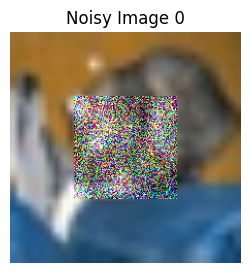

In [20]:
for original_batch, labels in test_loader_CIFAR10:

    noisy_images = torch.stack([add_localized_noise(img,patch_size=100,stddev=0.5) for img in original_batch])

    for i in range(len(noisy_images)):
        show_image(noisy_images[i], title=f'Noisy Image {i}')

        original_image = original_batch[i]
        # show_image(original_image, title=f'Original Image {i}')
        break
    break

# To display noisy images created via class
# for noisy_images, labels in noisy_cifar10_loader:
#     for i in range(len(noisy_images)):
#         show_image(noisy_images[i], title=f'Noisy Image {i}')
#         break
#     break

### Testing on the Injected Noise Dataset

In [21]:
# train_loader = noisy_cifar10_loader_train
test_loader = noisy_cifar10_loader_test
test_dataset = noisy_cifar10_data_test #to be used in CLIP

print(f"Total number of images in subset: {len(test_loader.dataset)}")

Total number of images in subset: 1000


Vit

In [ ]:
#testing
criterion = nn.CrossEntropyLoss()

print("=====ON NORMAL TEST SET=====")
vit_accuracy, vit_avg_loss = evaluate_model(vit_model, test_loader_CIFAR10, criterion, device)
print(f"\nViT - Accuracy: {vit_accuracy:.2f}% Loss: {vit_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
vit_accuracy, vit_avg_loss = evaluate_model(vit_model, test_loader, criterion, device)
print(f"\nViT - Accuracy: {vit_accuracy:.2f}% Loss: {vit_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:12<00:00,  1.53s/it]



Model Evaluation - Accuracy: 97.40% | Loss: 0.0835

ViT - Accuracy: 97.40% Loss: 0.0835
=====
ON Modified TEST SET=====


100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Model Evaluation - Accuracy: 93.40% | Loss: 0.2134

ViT - Accuracy: 93.40% Loss: 0.2134


VGG 16

In [ ]:
#testing
criterion = nn.CrossEntropyLoss()
print("=====ON NORMAL TEST SET=====")
vgg_accuracy, vgg_avg_loss = evaluate_model(vgg_model, test_loader_CIFAR10, criterion, device)
print(f"\nVGG - Accuracy: {vgg_accuracy:.2f}% Loss: {vgg_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
vgg_accuracy, vgg_avg_loss = evaluate_model(vgg_model, test_loader, criterion, device)
print(f"\nVGG - Accuracy: {vgg_accuracy:.2f}% Loss: {vgg_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]



Model Evaluation - Accuracy: 77.90% | Loss: 0.6605

VGG - Accuracy: 77.90% Loss: 0.6605
=====
ON Modified TEST SET=====


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Model Evaluation - Accuracy: 26.40% | Loss: 2.2863

VGG - Accuracy: 26.40% Loss: 2.2863


Resnet

In [ ]:
criterion = nn.CrossEntropyLoss()
print("=====ON NORMAL TEST SET=====")
resnet_accuracy, resnet_avg_loss = evaluate_model(resnet_model, test_loader_CIFAR10, criterion, device)
print(f"\nResNet - Accuracy: {resnet_accuracy:.2f}% Loss: {resnet_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
resnet_accuracy, resnet_avg_loss = evaluate_model(resnet_model, test_loader, criterion, device)
print(f"\nResNet - Accuracy: {resnet_accuracy:.2f}% Loss: {resnet_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]



Model Evaluation - Accuracy: 75.40% | Loss: 0.7191

ResNet - Accuracy: 75.40% Loss: 0.7191
=====
ON Modified TEST SET=====


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Model Evaluation - Accuracy: 10.00% | Loss: 810.4775

ResNet - Accuracy: 10.00% Loss: 810.4775


Clip-Vit-Base

In [23]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
cifar_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

clip_model.eval()

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = [f"a photo of a {class_name}" for class_name in class_names]

# Zero-shot evaluation on the test dataset with accuracy computation
correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating", leave=True):
        images = [img.to(device) for img in images]
        targets = targets.to(device)

        # Normalize and clamp images to ensure they are in the range [0, 1]
        images = [img.clamp(0, 1) for img in images]

        # Process inputs for the CLIP model
        inputs = cifar_processor(text=labels, images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)

        # Forward pass
        outputs = clip_model(**inputs)

        # Get image-text similarity scores
        logits_per_image = outputs.logits_per_image

        # Compute probabilities using softmax
        probs = logits_per_image.softmax(dim=1)

        # Get predicted labels (as indices)
        preds = torch.argmax(probs, dim=1)

        # Calculate accuracy
        correct += (preds == targets).sum().item()
        total += targets.size(0)

print("=====ON NORMAL TEST SET=====")
print(f"\nZero-shot classification accuracy on NOISY CIFAR-10: {CLIP_Accuracy:.4f}%")


print("=====\nON Modified TEST SET=====")
# Final accuracy
accuracy = correct / total * 100
print(f"\nZero-shot classification accuracy on NOISY CIFAR-10: {accuracy:.4f}%")

Evaluating: 100%|██████████| 8/8 [00:50<00:00,  6.27s/it]

=====ON NORMAL TEST SET=====

Zero-shot classification accuracy on NOISY CIFAR-10: 95.3000%
=====
ON Modified TEST SET=====

Zero-shot classification accuracy on NOISY CIFAR-10: 79.9000%


# 2 - Global Style Changes in Dataset:

In [ ]:
# # Load a pre-trained VGG model for style transfer
# vgg = models.vgg19(pretrained=True).features.eval()

# # Function to extract features from the VGG model
# def get_features(image, model, layers=None):
#     if layers is None:
#         layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}

#     features = {}
#     x = image
#     for name, layer in model._modules.items():
#         x = layer(x)
#         if name in layers:
#             features[layers[name]] = x
#     return features

# # Function to compute the Gram matrix (used for style loss)
# def gram_matrix(tensor):
#     if len(tensor.size()) == 3:  # If the tensor is missing a batch dimension
#         tensor = tensor.unsqueeze(0)  # Add a batch dimension
#     _, d, h, w = tensor.size()  # Unpack the dimensions
#     tensor = tensor.view(d, h * w)  # Reshape the tensor to (channels, height * width)
#     gram = torch.mm(tensor, tensor.t())  # Compute the Gram matrix
#     return gram


# # Load a style image and transform it
# style_image = Image.open("style.jpeg")
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])
# style_image = transform(style_image)

# style_features = get_features(style_image, vgg)

# # Function to apply style transfer
# def apply_style_transfer(content_image, style_image, num_steps=50, style_weight=1000000, content_weight=1):
#     # Ensure the images are 4D by adding a batch dimension if necessary
#     if content_image.dim() == 3:
#         content_image = content_image.unsqueeze(0)
#     if style_image.dim() == 3:
#         style_image = style_image.unsqueeze(0)

#     # Pass the images through the VGG model to extract features
#     content_features = get_features(content_image, vgg)
#     style_features = get_features(style_image, vgg)

#     # Compute the Gram matrices for the style image
#     style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

#     # Initialize the target image (content image to be optimized)
#     target = content_image.clone().requires_grad_(True)
#     optimizer = optim.Adam([target], lr=0.01)
#     loss_fn = torch.nn.MSELoss()

#     for step in range(num_steps):
#         # Extract the target features
#         target_features = get_features(target, vgg)

#         # Compute the content loss
#         content_loss = content_weight * loss_fn(target_features['conv4_2'], content_features['conv4_2'])

#         # Compute the style loss
#         style_loss = 0
#         for layer in style_grams:
#             target_gram = gram_matrix(target_features[layer])
#             d, d_ = target_gram.size()  # Since it's a 2D matrix (channels, channels)
#             style_loss += style_weight * loss_fn(target_gram, style_grams[layer]) / (d * d_)

#         # Total loss
#         total_loss = content_loss + style_loss

#         # Backpropagation
#         optimizer.zero_grad()
#         total_loss.backward(retain_graph=True)
#         optimizer.step()

#         # Optionally, print the loss for each step
#         print(f"Step {step}, Total loss: {total_loss.item()}")

#     return target.squeeze(0)  # Remove the batch dimension after optimization



# # Example: applying style transfer on CIFAR-10 images
# def style_transfer_image(image, style_image):
#     return apply_style_transfer(image, style_image)

# # Function to apply a color shift
# def apply_color_shift(image, shift_value=0.2):
#     transform = transforms.ColorJitter(hue=shift_value)  # Adjust hue by the shift_value
#     return transform(image)



In [26]:
# Load a pre-trained VGG model for style transfer
vgg = models.vgg19(pretrained=True).features

def apply_style_transfer(content_image, style_image, num_steps=15, style_weight=100, content_weight=1):
    content_image = content_image.unsqueeze(0)
    style_image = style_image.unsqueeze(0)

    optimizer = optim.Adam([content_image.requires_grad_()], lr=0.01)
    loss_fn = torch.nn.MSELoss()

    for step in range(num_steps):
        # Compute style loss and content loss
        content_loss = loss_fn(content_image, style_image)
        style_loss = loss_fn(content_image, style_image)
        loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return content_image.squeeze(0)

def style_transfer_image(image, style_image):
    return apply_style_transfer(image, style_image)

def apply_color_shift(image, shift_value=0.2):
    transform = transforms.ColorJitter(hue=shift_value)  # Adjust hue by the shift_value
    return transform(image)

style_image = Image.open("style.jpeg")
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
style_image = transform(style_image)

In [27]:
class StyledCIFAR10(Dataset):
    def __init__(self, original_dataset, style_image=None, color_shift=False, shift_value=0.2):
        self.dataset = original_dataset
        self.style_image = style_image
        self.color_shift = color_shift
        self.shift_value = shift_value

        #applying style transfer or color shift during initialization
        self.processed_images = []
        self.labels = []

        for idx in tqdm(range(len(self.dataset)), desc="Processing Images"):
            image, label = self.dataset[idx]

            # Apply style transfer or color shift during initialization
            if self.style_image is not None:
                image = style_transfer_image(image, self.style_image)
            elif self.color_shift:
                image = apply_color_shift(image, self.shift_value)

            self.processed_images.append(image)
            self.labels.append(label)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.processed_images[idx], self.labels[idx]

Processing Images: 100%|██████████| 1000/1000 [00:29<00:00, 34.14it/s]


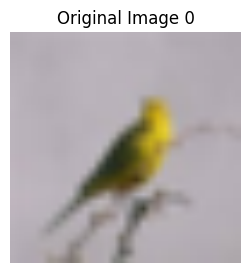

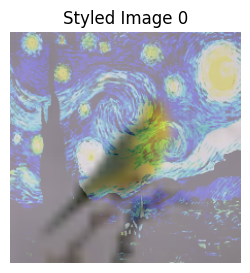

In [28]:
# Create a styled CIFAR-10 dataset (using style transfer or color shift)
# styled_cifar10_data_train = StyledCIFAR10(train_dataset_CIFAR10, style_image=style_image)
styled_cifar10_data_test  = StyledCIFAR10(test_dataset_CIFAR10, style_image=style_image)

# color_shifted_cifar10_data_train = StyledCIFAR10(train_dataset_CIFAR10, color_shift=True, shift_value=0.2)
# color_shifted_cifar10_data_test  = StyledCIFAR10(test_dataset_CIFAR10, color_shift=True, shift_value=0.2)

# Create DataLoader for the new dataset
# styled_cifar10_loader_train = DataLoader(styled_cifar10_data_train, batch_size=128, shuffle=True)
styled_cifar10_loader_test  = DataLoader(styled_cifar10_data_test, batch_size=128, shuffle=True)

# color_shifted_cifar10_loader_train = DataLoader(color_shifted_cifar10_data_train, batch_size=64, shuffle=True)
# color_shifted_cifar10_loader_test  = DataLoader(color_shifted_cifar10_data_test, batch_size=64, shuffle=True)

for images, labels in train_loader_CIFAR10:
  for i in range(len(images)):
    show_image(images[i], title=f'Original Image {i}')
    styled_image = apply_style_transfer(images[i], style_image)

    show_image(styled_image, title=f'Styled Image {i}')
    break
  break

# for images, labels in color_shifted_cifar10_loader_train:
#   for i in range(len(images)):
#     show_image(images[i], title=f'Color Shifted Image {i}')
#     break
#   break

### Testing on the Global Style Changes Dataset

In [29]:
# train_loader = noisy_cifar10_loader_train
test_loader  = styled_cifar10_loader_test
test_dataset = styled_cifar10_data_test #to be used in CLIP

print(f"Total number of images in subset: {len(test_loader.dataset)}")

Total number of images in subset: 1000


ViT

In [ ]:
#testing
criterion = nn.CrossEntropyLoss()

print("=====ON NORMAL TEST SET=====")
vit_accuracy, vit_avg_loss = evaluate_model(vit_model, test_loader_CIFAR10, criterion, device)
print(f"\nViT - Accuracy: {vit_accuracy:.2f}% Loss: {vit_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
vit_accuracy, vit_avg_loss = evaluate_model(vit_model, test_loader, criterion, device)
print(f"\nViT - Accuracy: {vit_accuracy:.2f}% Loss: {vit_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:12<00:00,  1.57s/it]



Model Evaluation - Accuracy: 97.40% | Loss: 0.0835

ViT - Accuracy: 97.40% Loss: 0.0835
=====
ON Modified TEST SET=====


100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


Model Evaluation - Accuracy: 96.20% | Loss: 0.1513

ViT - Accuracy: 96.20% Loss: 0.1513


VGG 16

In [ ]:
#testing
criterion = nn.CrossEntropyLoss()
print("=====ON NORMAL TEST SET=====")
vgg_accuracy, vgg_avg_loss = evaluate_model(vgg_model, test_loader_CIFAR10, criterion, device)
print(f"\nVGG - Accuracy: {vgg_accuracy:.2f}% Loss: {vgg_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
vgg_accuracy, vgg_avg_loss = evaluate_model(vgg_model, test_loader, criterion, device)
print(f"\nVGG - Accuracy: {vgg_accuracy:.2f}% Loss: {vgg_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:08<00:00,  1.04s/it]



Model Evaluation - Accuracy: 77.90% | Loss: 0.6605

VGG - Accuracy: 77.90% Loss: 0.6605
=====
ON Modified TEST SET=====


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Model Evaluation - Accuracy: 54.30% | Loss: 1.3278

VGG - Accuracy: 54.30% Loss: 1.3278


ResNet

In [ ]:
criterion = nn.CrossEntropyLoss()
print("=====ON NORMAL TEST SET=====")
resnet_accuracy, resnet_avg_loss = evaluate_model(resnet_model, test_loader_CIFAR10, criterion, device)
print(f"\nResNet - Accuracy: {resnet_accuracy:.2f}% Loss: {resnet_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
resnet_accuracy, resnet_avg_loss = evaluate_model(resnet_model, test_loader, criterion, device)
print(f"\nResNet - Accuracy: {resnet_accuracy:.2f}% Loss: {resnet_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]



Model Evaluation - Accuracy: 75.40% | Loss: 0.7191

ResNet - Accuracy: 75.40% Loss: 0.7191
=====
ON Modified TEST SET=====


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Model Evaluation - Accuracy: 19.90% | Loss: 7.7870

ResNet - Accuracy: 19.90% Loss: 7.7870


Clip-ViT-Base

In [30]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
cifar_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

clip_model.eval()

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = [f"a photo of a {class_name}" for class_name in class_names]

# Zero-shot evaluation on the test dataset with accuracy computation
correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating", leave=True):
        images = [img.to(device) for img in images]
        targets = targets.to(device)

        # Normalize and clamp images to ensure they are in the range [0, 1]
        images = [img.clamp(0, 1) for img in images]

        # Process inputs for the CLIP model
        inputs = cifar_processor(text=labels, images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)

        # Forward pass
        outputs = clip_model(**inputs)

        # Get image-text similarity scores
        logits_per_image = outputs.logits_per_image

        # Compute probabilities using softmax
        probs = logits_per_image.softmax(dim=1)

        # Get predicted labels (as indices)
        preds = torch.argmax(probs, dim=1)

        # Calculate accuracy
        correct += (preds == targets).sum().item()
        total += targets.size(0)

print("=====ON NORMAL TEST SET=====")
print(f"\nZero-shot classification accuracy on NOISY CIFAR-10: {CLIP_Accuracy:.4f}%")


print("=====\nON Modified TEST SET=====")
# Final accuracy
accuracy = correct / total * 100
print(f"\nZero-shot classification accuracy on NOISY CIFAR-10: {accuracy:.4f}%")

Evaluating: 100%|██████████| 8/8 [00:50<00:00,  6.35s/it]

=====ON NORMAL TEST SET=====

Zero-shot classification accuracy on NOISY CIFAR-10: 95.3000%
=====
ON Modified TEST SET=====

Zero-shot classification accuracy on NOISY CIFAR-10: 25.8000%


# 3 - Scrambled Images in Dataset:

In [31]:
def scramble_image(image, patch_size=8):
    c, h, w = image.shape
    patches = []

    # Split the image into patches
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)

    # Shuffle patches randomly
    np.random.shuffle(patches)

    # Reassemble the scrambled image
    scrambled_image = torch.zeros_like(image)
    patch_idx = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            scrambled_image[:, i:i+patch_size, j:j+patch_size] = patches[patch_idx]
            patch_idx += 1

    return scrambled_image

class ScrambledCIFAR10(Dataset):
    def __init__(self, original_dataset, patch_size=8):
        self.dataset = original_dataset
        self.patch_size = patch_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        scrambled_image = scramble_image(image, patch_size=self.patch_size)
        return scrambled_image, label


scrambled_cifar10_data_test  = ScrambledCIFAR10(test_dataset_CIFAR10, patch_size=16)
scrambled_cifar10_loader_test = DataLoader(scrambled_cifar10_data_test, batch_size=64, shuffle=True)

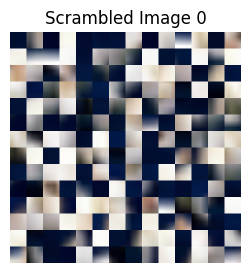

In [32]:
for scrambled_images, labels in scrambled_cifar10_loader_test:
    for i in range(len(scrambled_images)):
        show_image(scrambled_images[i], title=f'Scrambled Image {i}')
        break
    break

### Testing on the Scrambled Images Dataset

In [33]:
# train_loader = noisy_cifar10_loader_train
test_loader = scrambled_cifar10_loader_test
test_dataset = scrambled_cifar10_data_test #to be used in CLIP

print(f"Total number of images in subset: {len(test_loader.dataset)}")

Total number of images in subset: 1000


### Testing With 16 as Patch Size

ViT

In [ ]:
#testing
criterion = nn.CrossEntropyLoss()

print("=====ON NORMAL TEST SET=====")
vit_accuracy, vit_avg_loss = evaluate_model(vit_model, test_loader_CIFAR10, criterion, device)
print(f"\nViT - Accuracy: {vit_accuracy:.2f}% Loss: {vit_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
vit_accuracy, vit_avg_loss = evaluate_model(vit_model, test_loader, criterion, device)
print(f"\nViT - Accuracy: {vit_accuracy:.2f}% Loss: {vit_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:13<00:00,  1.64s/it]



Model Evaluation - Accuracy: 97.40% | Loss: 0.0835

ViT - Accuracy: 97.40% Loss: 0.0835
=====
ON Modified TEST SET=====


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Model Evaluation - Accuracy: 27.00% | Loss: 2.1634

ViT - Accuracy: 27.00% Loss: 2.1634


VGG

In [ ]:
#testing
criterion = nn.CrossEntropyLoss()
print("=====ON NORMAL TEST SET=====")
vgg_accuracy, vgg_avg_loss = evaluate_model(vgg_model, test_loader_CIFAR10, criterion, device)
print(f"\nVGG - Accuracy: {vgg_accuracy:.2f}% Loss: {vgg_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
vgg_accuracy, vgg_avg_loss = evaluate_model(vgg_model, test_loader, criterion, device)
print(f"\nVGG - Accuracy: {vgg_accuracy:.2f}% Loss: {vgg_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]



Model Evaluation - Accuracy: 77.90% | Loss: 0.6605

VGG - Accuracy: 77.90% Loss: 0.6605
=====
ON Modified TEST SET=====


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


Model Evaluation - Accuracy: 12.00% | Loss: 3.8176

VGG - Accuracy: 12.00% Loss: 3.8176


ResNet

In [ ]:
criterion = nn.CrossEntropyLoss()
print("=====ON NORMAL TEST SET=====")
resnet_accuracy, resnet_avg_loss = evaluate_model(resnet_model, test_loader_CIFAR10, criterion, device)
print(f"\nResNet - Accuracy: {resnet_accuracy:.2f}% Loss: {resnet_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
resnet_accuracy, resnet_avg_loss = evaluate_model(resnet_model, test_loader, criterion, device)
print(f"\nResNet - Accuracy: {resnet_accuracy:.2f}% Loss: {resnet_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]



Model Evaluation - Accuracy: 75.40% | Loss: 0.7191

ResNet - Accuracy: 75.40% Loss: 0.7191
=====
ON Modified TEST SET=====


100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Model Evaluation - Accuracy: 12.70% | Loss: 2.5639

ResNet - Accuracy: 12.70% Loss: 2.5639


CLIP

In [34]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
cifar_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

clip_model.eval()

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = [f"a photo of a {class_name}" for class_name in class_names]

# Zero-shot evaluation on the test dataset with accuracy computation
correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating", leave=True):
        images = [img.to(device) for img in images]
        targets = targets.to(device)

        # Normalize and clamp images to ensure they are in the range [0, 1]
        images = [img.clamp(0, 1) for img in images]

        # Process inputs for the CLIP model
        inputs = cifar_processor(text=labels, images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)

        # Forward pass
        outputs = clip_model(**inputs)

        # Get image-text similarity scores
        logits_per_image = outputs.logits_per_image

        # Compute probabilities using softmax
        probs = logits_per_image.softmax(dim=1)

        # Get predicted labels (as indices)
        preds = torch.argmax(probs, dim=1)

        # Calculate accuracy
        correct += (preds == targets).sum().item()
        total += targets.size(0)

print("=====ON NORMAL TEST SET=====")
print(f"\nZero-shot classification accuracy on NOISY CIFAR-10: {CLIP_Accuracy:.4f}%")


print("=====\nON Modified TEST SET=====")
# Final accuracy
accuracy = correct / total * 100
print(f"\nZero-shot classification accuracy on NOISY CIFAR-10: {accuracy:.4f}%")

Evaluating: 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]

=====ON NORMAL TEST SET=====

Zero-shot classification accuracy on NOISY CIFAR-10: 95.3000%
=====
ON Modified TEST SET=====

Zero-shot classification accuracy on NOISY CIFAR-10: 26.5000%


### Testing With 32 as Patch Size

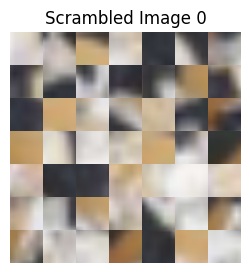

Total number of images in subset: 1000


In [35]:
scrambled_cifar10_data_test  = ScrambledCIFAR10(test_dataset_CIFAR10, patch_size=32)
scrambled_cifar10_loader_test = DataLoader(scrambled_cifar10_data_test, batch_size=64, shuffle=True)

for scrambled_images, labels in scrambled_cifar10_loader_test:
    for i in range(len(scrambled_images)):
        show_image(scrambled_images[i], title=f'Scrambled Image {i}')
        break
    break

# train_loader = noisy_cifar10_loader_train
test_loader = scrambled_cifar10_loader_test
test_dataset = scrambled_cifar10_data_test #to be used in CLIP

print(f"Total number of images in subset: {len(test_loader.dataset)}")

ViT

In [ ]:
#testing
criterion = nn.CrossEntropyLoss()

print("=====ON NORMAL TEST SET=====")
vit_accuracy, vit_avg_loss = evaluate_model(vit_model, test_loader_CIFAR10, criterion, device)
print(f"\nViT - Accuracy: {vit_accuracy:.2f}% Loss: {vit_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
vit_accuracy, vit_avg_loss = evaluate_model(vit_model, test_loader, criterion, device)
print(f"\nViT - Accuracy: {vit_accuracy:.2f}% Loss: {vit_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]



Model Evaluation - Accuracy: 97.40% | Loss: 0.0835

ViT - Accuracy: 97.40% Loss: 0.0835
=====
ON Modified TEST SET=====


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


Model Evaluation - Accuracy: 53.50% | Loss: 1.4588

ViT - Accuracy: 53.50% Loss: 1.4588


Vgg

In [ ]:
#testing
criterion = nn.CrossEntropyLoss()
print("=====ON NORMAL TEST SET=====")
vgg_accuracy, vgg_avg_loss = evaluate_model(vgg_model, test_loader_CIFAR10, criterion, device)
print(f"\nVGG - Accuracy: {vgg_accuracy:.2f}% Loss: {vgg_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
vgg_accuracy, vgg_avg_loss = evaluate_model(vgg_model, test_loader, criterion, device)
print(f"\nVGG - Accuracy: {vgg_accuracy:.2f}% Loss: {vgg_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]



Model Evaluation - Accuracy: 77.90% | Loss: 0.6605

VGG - Accuracy: 77.90% Loss: 0.6605
=====
ON Modified TEST SET=====


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


Model Evaluation - Accuracy: 11.90% | Loss: 4.2885

VGG - Accuracy: 11.90% Loss: 4.2885


ResNet

In [ ]:
criterion = nn.CrossEntropyLoss()
print("=====ON NORMAL TEST SET=====")
resnet_accuracy, resnet_avg_loss = evaluate_model(resnet_model, test_loader_CIFAR10, criterion, device)
print(f"\nResNet - Accuracy: {resnet_accuracy:.2f}% Loss: {resnet_avg_loss:.4f}")

print("=====\nON Modified TEST SET=====")
resnet_accuracy, resnet_avg_loss = evaluate_model(resnet_model, test_loader, criterion, device)
print(f"\nResNet - Accuracy: {resnet_accuracy:.2f}% Loss: {resnet_avg_loss:.4f}")

=====ON NORMAL TEST SET=====


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]



Model Evaluation - Accuracy: 75.40% | Loss: 0.7191

ResNet - Accuracy: 75.40% Loss: 0.7191
=====
ON Modified TEST SET=====


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


Model Evaluation - Accuracy: 23.70% | Loss: 2.1670

ResNet - Accuracy: 23.70% Loss: 2.1670


CLIP

In [36]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
cifar_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

clip_model.eval()

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = [f"a photo of a {class_name}" for class_name in class_names]

# Zero-shot evaluation on the test dataset with accuracy computation
correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating", leave=True):
        images = [img.to(device) for img in images]
        targets = targets.to(device)

        # Normalize and clamp images to ensure they are in the range [0, 1]
        images = [img.clamp(0, 1) for img in images]

        # Process inputs for the CLIP model
        inputs = cifar_processor(text=labels, images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)

        # Forward pass
        outputs = clip_model(**inputs)

        # Get image-text similarity scores
        logits_per_image = outputs.logits_per_image

        # Compute probabilities using softmax
        probs = logits_per_image.softmax(dim=1)

        # Get predicted labels (as indices)
        preds = torch.argmax(probs, dim=1)

        # Calculate accuracy
        correct += (preds == targets).sum().item()
        total += targets.size(0)

print("=====ON NORMAL TEST SET=====")
print(f"\nZero-shot classification accuracy on NOISY CIFAR-10: {CLIP_Accuracy:.4f}%")


print("=====\nON Modified TEST SET=====")
# Final accuracy
accuracy = correct / total * 100
print(f"\nZero-shot classification accuracy on NOISY CIFAR-10: {accuracy:.4f}%")

Evaluating: 100%|██████████| 16/16 [00:52<00:00,  3.26s/it]

=====ON NORMAL TEST SET=====

Zero-shot classification accuracy on NOISY CIFAR-10: 95.3000%
=====
ON Modified TEST SET=====

Zero-shot classification accuracy on NOISY CIFAR-10: 46.0000%


Saving the Weights

In [ ]:
# Save only the classifier parameters
torch.save(vit_model.head.state_dict(), "vit_finetuned_classifier.pth")
torch.save(vgg_model.head.state_dict(), "vgg_finetuned_classifier.pth")
torch.save(resnet_model.fc.state_dict(), "resnet_finetuned_classifier.pth")

print("Model weights saved successfully.")

#Reuse Weights Via
# # Initialize the model (same architecture)
# vit_model = timm.create_model('vit_base_patch16_224', pretrained=False)
# vit_model.head = nn.Linear(vit_model.head.in_features, 10)

# # Load the saved weights
# vit_model.head.load_state_dict(torch.load("vit_finetuned_classifier.pth"))

# # Move the model to the appropriate device (e.g., GPU)
# vit_model = vit_model.to(device)

# print("Model weights loaded successfully.")

Model weights saved successfully.


In [ ]:
import zipfile

# File names to zip
files_to_zip = ["vit_finetuned_classifier.pth", "vgg_finetuned_classifier.pth", "resnet_finetuned_classifier.pth"]
zip_filename = "/content/fine_tuned_models.zip"

# Create a zip file and add the model files
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)

zip_filename

'/content/fine_tuned_models.zip'

In [ ]:
import os
# print size of zip file in mbs
# print size of zip file in mbs
print("Size of the zip file:", os.path.getsize(zip_filename), "bytes")

Size of the zip file: 282228 bytes
